In [1]:
%matplotlib inline
from rotplot import *
from astropy.stats import LombScargle, median_absolute_deviation

import sys
sys.path.append('/Users/ellie/Research/flareninja/gpmodel/')

In [2]:
#star('12092361-3815424', south=True)
prefix='2massj'
ls = '12092361-3815424'
lc = pickle.load( open("data/"+prefix+ls+".pkl", "rb") )

True True True


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'texgyrepagella'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


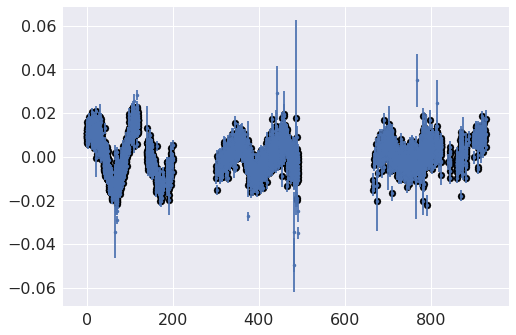

In [3]:
trim = (lc.eflux < 0.1) & ( np.abs(lc.flux_reduce()) < 0.05 )

t = np.array(lc.time[trim])
y = np.array(lc.flux_reduce()[trim])
yerr = np.array(lc.eflux[trim])

plt.errorbar(t,y,yerr, fmt='.')

print  np.all(t[1:]), np.all(y), np.all(yerr)

# Do some aggressive sigma clipping
m = np.ones(len(t), dtype=bool)
while True:
    mu = np.mean(y[m])
    sig = np.std(y[m])
    m0 = np.abs(y - mu) < 3 * sig
    if np.all(m0 == m):
        break
    m = m0

t_orig, y_orig, yerr_orig = np.copy(t), np.copy(y), np.copy(yerr)
t, y, yerr = t[m], y[m], yerr[m]

plt.scatter(t,y,c='k')


In [13]:
period = 110.
min_period = period * 0.7
max_period = period / 0.7

import celerite
from mixterm import MixtureOfSHOsTerm
from celerite import terms

def get_rotation_gp(t, y, yerr, period, min_period, max_period):
    kernel = terms.SHOTerm(
        log_S0=np.log(np.var(y)),
        log_Q=-np.log(4.0),
        log_omega0=np.log(2*np.pi/1000.), ## this is supposed to be a slowly varying term
        bounds=dict(
            log_S0=(-20.0, 10.0),
            log_omega0=(np.log(2*np.pi/10000.0), np.log(2*np.pi/200.)),
        ),
    )
    kernel.freeze_parameter('log_Q')

    # Finally some jitter
    kernel += terms.JitterTerm(log_sigma=np.log(np.median(yerr)),
                               bounds=[(-20.0, 5.0)])
    
    kernel += MixtureOfSHOsTerm(
        log_a=-13., ## amplitude of the main peak
        log_Q1=np.log(15), ## decay timescale of the main peak (which is the width of the spike in the FT)
        mix_par=np.log(2), ## height of main peak relative to second harmonic
        log_Q2=np.log(15), ## decay timescale of the second peak
        log_P=np.log(period), ## period
        bounds=dict(
            log_a=(-20.0, 10.0),
            log_Q1=(-0.5*np.log(2.0), 8.0),
            mix_par=(-5.0, 5.0),
            log_Q2=(-0.5*np.log(2.0), 8.0),
            log_P=(np.log(min_period), np.log(max_period)),
        )
    )
    print kernel.get_parameter_names()
    kernel.freeze_parameter('terms[2]:log_a')
    
    gp = celerite.GP(kernel=kernel, mean=0.)
    gp.compute(t)
    return gp
gp = get_rotation_gp(t, y, yerr, period, min_period, max_period)
#gp = get_simple_gp(t, y, yerr)
initial_params = gp.get_parameter_vector()
gp.compute(t, yerr)  # You always need to call compute once.

print(gp.get_parameter_names())

print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))



('terms[0]:log_S0', 'terms[0]:log_omega0', 'terms[1]:log_sigma', 'terms[2]:log_a', 'terms[2]:log_Q1', 'terms[2]:mix_par', 'terms[2]:log_Q2', 'terms[2]:log_P')
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_sigma', 'kernel:terms[2]:log_Q1', 'kernel:terms[2]:mix_par', 'kernel:terms[2]:log_Q2', 'kernel:terms[2]:log_P')
Initial log likelihood: 23795.1972787


In [14]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)
gp.get_parameter_dict()

      fun: -23993.475642107765
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.18278728e-02, -5.26270014e+00,  1.37151801e-01, -8.36735126e-03,
       -4.36557457e-03,  7.73798092e+00, -6.94490154e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 440
      nit: 41
   status: 0
  success: True
        x: array([-4.42674497, -3.4604403 , -6.0395468 ,  8.        ,  4.25158407,
       -0.34657359,  4.73570455])


OrderedDict([('kernel:terms[0]:log_S0', -4.426744969765666),
             ('kernel:terms[0]:log_omega0', -3.460440300138691),
             ('kernel:terms[1]:log_sigma', -6.039546803292695),
             ('kernel:terms[2]:log_Q1', 8.0),
             ('kernel:terms[2]:mix_par', 4.251584071564372),
             ('kernel:terms[2]:log_Q2', -0.34657359027997264),
             ('kernel:terms[2]:log_P', 4.735704550572555)])

In [15]:
x = np.linspace(t[0], t[-1], 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

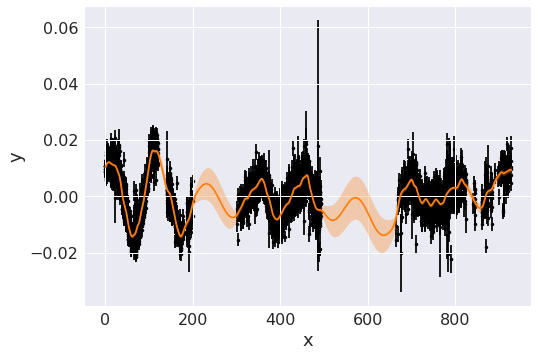

In [16]:
color = "#ff7f0e"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, zorder=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
#plt.xlim(0, 10)
#plt.ylim(-2.5, 2.5);

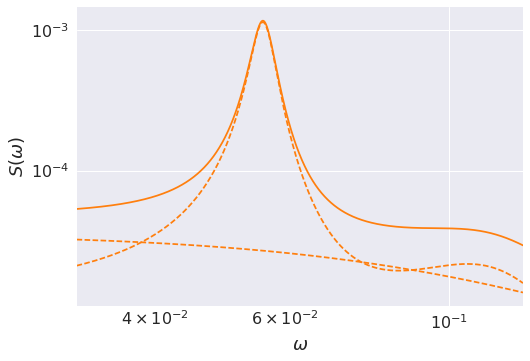

In [8]:
omega = 2*np.pi*np.exp(np.linspace(np.log(1./200.0), np.log(1.0/50.0), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [9]:
np.log(np.var(y)) # this doesn't (neither does -10.)

-9.756921223089794

In [10]:
np.log(0.001**2) # this works (so does -13.)

-13.815510557964274